In [1]:
import pandas as pd
import numpy as np
import pvlib
import datetime
from solar_forecaster.herbie_gefs_tools import get_tcc_fcasts_fastherbie, get_tcc_fcast
from solar_forecaster.herbie_hrrr_tools import get_hrrr_fcasts_fastherbie, hrrr_ds_to_power
import matplotlib.pyplot as plt
import xgboost as xgb
from quantile_forest import RandomForestQuantileRegressor
import joblib

Load plant specs:

In [2]:
plants_df = pd.read_csv('pv_fleet_metadata_rev3.csv') # read in as a Pandas DataFrame
plants_df = plants_df[plants_df['ac_capacity']>=10].copy().reset_index()
num_plants = len(plants_df.index) # number of plants

Calculate initialization time for GEFS:

In [3]:
# get delay_to_first_forecast and update_freq from 
# https://github.com/SolarArbiter/solarforecastarbiter-core/blob/master/solarforecastarbiter/io/fetch/nwp.py
delay_to_first_forecast = '280min'
update_freq = '6h'

time_now = pd.Timestamp(datetime.datetime.now().isoformat())
init_time = (time_now - pd.Timedelta(delay_to_first_forecast)).floor(update_freq)
print(init_time)

2024-04-16 00:00:00


Get GEFS data:

In [4]:
num_members = 30 # Number of ensemble members to pull, max of 30
freq='1D' # how often to pull a new forecast
fxx_interval = 3 # time step of the forecast, GEFS has 3 hour intervals
fxx_range = range(12,46,fxx_interval)

# lat, lon extent for region of interest
# (left lon, right lon, lower lat, upper lat)
region_extent = [-92, -80, 29, 36]

start = init_time
end = init_time

save_dir = 'nc_files/gefs/'
remove_grib=True
w_avg_tcc = get_tcc_fcasts_fastherbie(start, end, freq, fxx_range, plants_df,
                              region_extent=region_extent, num_members=num_members,
                              save=False, save_dir='', attempts=5, remove_grib=True)

# clean up indices and localize to UTC
w_avg_tcc = w_avg_tcc.reset_index().set_index('valid_time_utc_end_of_interval').tz_localize('UTC')
w_avg_tcc.head()

downloading new data


👨🏻‍🏭 Created directory: [C:\Users\willh\data\gefs\20240416]
member 1 download complete
member 2 download complete
member 3 download complete
member 4 download complete
member 5 download complete
member 6 download complete
member 7 download complete
member 8 download complete
member 9 download complete
member 10 download complete
member 11 download complete
member 12 download complete
member 13 download complete
member 14 download complete
member 15 download complete
member 16 download complete
member 17 download complete
member 18 download complete
member 19 download complete
member 20 download complete
member 21 download complete
member 22 download complete
member 23 download complete
member 24 download complete
member 25 download complete
member 26 download complete
member 27 download complete
member 28 download complete
member 29 download complete
member 30 download complete
downloaded and processed 


,time_utc,step,tcc_std,tcc_p01,tcc_p02,tcc_p03,tcc_p04,tcc_p05,tcc_p06,tcc_p07,...,tcc_p21,tcc_p22,tcc_p23,tcc_p24,tcc_p25,tcc_p26,tcc_p27,tcc_p28,tcc_p29,tcc_p30
valid_time_utc_end_of_interval,,,,,,,,,,,,,,,,,,,,,
2024-04-16 10:00:00+00:00,2024-04-16,0 days 12:00:00,6.015567,80.973092,87.024137,74.782257,81.172322,83.157522,79.905148,73.152356,...,82.516293,68.694481,89.095202,78.924656,79.825606,83.500686,83.585206,81.878078,77.165702,77.554611
2024-04-16 11:00:00+00:00,2024-04-16,0 days 12:00:00,6.015567,80.973092,87.024137,74.782257,81.172322,83.157522,79.905148,73.152356,...,82.516293,68.694481,89.095202,78.924656,79.825606,83.500686,83.585206,81.878078,77.165702,77.554611
2024-04-16 12:00:00+00:00,2024-04-16,0 days 12:00:00,6.015567,80.973092,87.024137,74.782257,81.172322,83.157522,79.905148,73.152356,...,82.516293,68.694481,89.095202,78.924656,79.825606,83.500686,83.585206,81.878078,77.165702,77.554611
2024-04-16 13:00:00+00:00,2024-04-16,0 days 15:00:00,6.746409,87.471760,90.265990,83.303474,90.461561,87.578828,87.496623,78.107096,...,93.657993,85.057773,86.476146,82.091220,84.107715,73.714070,77.940156,82.481527,81.708958,77.230606
2024-04-16 14:00:00+00:00,2024-04-16,0 days 15:00:00,6.746409,87.471760,90.265990,83.303474,90.461561,87.578828,87.496623,78.107096,...,93.657993,85.057773,86.476146,82.091220,84.107715,73.714070,77.940156,82.481527,81.708958,77.230606


Calculate initialization time for HRRR:

In [5]:
# get delay_to_first_forecast and update_freq from 
# https://github.com/SolarArbiter/solarforecastarbiter-core/blob/master/solarforecastarbiter/io/fetch/nwp.py
delay_to_first_forecast = '45min' 
update_freq = '6h' # HRRR updates hourly, but only goes out 48 hours at 00Z, 06Z, 12Z, and 18Z forecasts

time_now = pd.Timestamp(datetime.datetime.now().isoformat())
init_time = (time_now - pd.Timedelta(delay_to_first_forecast)).floor(update_freq)
print(init_time)

2024-04-16 06:00:00


Get HRRR data:

In [8]:
freq = '24h'
fxx_range = range(12,45)
query_len_days = 3

save_dir = 'nc_files/hrrr/'
remove_grib=True
region_extent=[220,440,1080,1440]

start = init_time
end = init_time

ds, _, _, _, _ = get_hrrr_fcasts_fastherbie(start, end, freq, fxx_range, plants_df,
                              region_extent=region_extent, save=False, 
                              save_dir='', attempts=5, transposition_model='perez',
                              decomposition_model='erbs', coarsen_type='none')

window_size = 10

# coarsened mean
ds_mean = ds.coarsen(x=window_size, y=window_size, boundary='trim').mean()
p_ac_all_fcast, _, p_ac_all_cs, _ = hrrr_ds_to_power(ds_mean,
                                plants_df,
                                transposition_model = 'perez',
                                decomposition_model = 'erbs',
                                eta_inv_nom = 0.98)

# coarsened max
ds_max = ds.coarsen(x=window_size, y=window_size, boundary='trim').max()
p_ac_all_fcast_max, _, _, _ = hrrr_ds_to_power(ds_max,
                                plants_df,
                                transposition_model = 'perez',
                                decomposition_model = 'erbs',
                                eta_inv_nom = 0.98)

# coarsened mmin
ds_min = ds.coarsen(x=window_size, y=window_size, boundary='trim').min()
p_ac_all_fcast_min, _, _, _ = hrrr_ds_to_power(ds_min,
                                plants_df,
                                transposition_model = 'perez',
                                decomposition_model = 'erbs',
                                eta_inv_nom = 0.98)

downloading new data
👨🏻‍🏭 Created directory: [C:\Users\willh\data\hrrr\20240416]
variable group 1 download complete
variable group 2 download complete
variable group 3 download complete
downloaded and processed 


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:258: UserWarning: More than one time coordinate present for variable  "t2m_c".
  ds = ds.metpy.parse_cf()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:258: UserWarning: More than one time coordinate present for variable  "wspd".
  ds = ds.metpy.parse_cf()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "dswrf".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "t2m".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\accessors.py:262: UserWarning: More than one time coordinate present for variable  "u10".
  ds = ds.metpy.assign_y_x()
c:\Users\willh\miniforge3\envs\pvlib_he

Load models that we trained previously:

In [9]:
booster = xgb.Booster()
booster.load_model("regression_models/xgboost_model.json")
qrf = joblib.load('regression_models/qrf_file.joblib')


pi_list_xgb = [.9995, .999, .99, .96, .57] 
pi_list_rf = [.995, .99, .98, .95, .5]

In [10]:
p_ac_all_cs.rename(columns={'power_ac': 'p_ac_all_cs'}, inplace=True)
p_ac_all_fcast.rename(columns={'power_ac': 'p_ac_all_fcast'}, inplace=True)
p_ac_all_fcast_max.rename(columns={'power_ac': 'p_ac_all_fcast_max'}, inplace=True)
p_ac_all_fcast_min.rename(columns={'power_ac': 'p_ac_all_fcast_min'}, inplace=True)

# list of dataframes to combine first
dfs = [
    p_ac_all_fcast,
    p_ac_all_fcast_max,
    p_ac_all_fcast_min,
    p_ac_all_cs,
    w_avg_tcc.tcc_std,
    ]

# combine all dataframes and drop na rows
df = pd.concat(dfs, axis=1).dropna()

df.index.name = 'time_center_labeled'

# calculate normalized max-min
df['max_min_norm'] = (df['p_ac_all_fcast_max'] - df['p_ac_all_fcast_min'])/df['p_ac_all_cs']

# normalize forecast to clear sky
df['csi_fcast'] = df['p_ac_all_fcast']/df['p_ac_all_cs']

latitude, longitude = 32.8 , -83.6
solpos = pvlib.solarposition.get_solarposition(time=df.index,latitude=latitude, longitude=longitude)

df['hour'] = df.index.hour
df['month'] = df.index.month
df['el'] = solpos.apparent_elevation
df['zen'] = solpos.apparent_zenith
df['az'] = solpos.azimuth

In [11]:
filtered_df = df.dropna()
approx_nameplate = plants_df['ac_capacity'].sum() 
filtered_df = filtered_df[filtered_df['p_ac_all_cs'] >= approx_nameplate*.001]

X=filtered_df[['tcc_std']].copy()
X['max_min_norm'] = filtered_df['max_min_norm']
X['csi_fcast'] = filtered_df['csi_fcast']
X['zen'] = filtered_df['zen']
X['az'] = filtered_df['az']
X['month'] = filtered_df['month']

In [12]:
y_pred = booster.inplace_predict(X)

In [13]:
pi_list = pi_list_xgb
percentile_list = [(1-x)/2 for x in pi_list] + [.5] + [1-(1-x)/2 for x in reversed(pi_list)]
percentile_list = [round(elem, 6) for elem in percentile_list]
num_intervals = len(pi_list)

# create a results dataframe
result_df = X.copy()

# merge orginal DF, marking duplicate columns and then dropping them
result_df = result_df.merge(df, left_index=True, right_index=True, suffixes=('', '_drop'))
result_df.drop(result_df.filter(regex='_drop$').columns, axis=1, inplace=True)

# adding CS-normalized quantiles/percentiles, and then un-normalizing them to get power
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_csi']=y_pred[:,i]
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_p_ac']=y_pred[:,i]*result_df['p_ac_all_cs']

# fill in overnight 
result_df = result_df.reset_index().set_index('time_center_labeled').asfreq('1h')

In [14]:
result_df_XGB = result_df.copy()

In [15]:
y_pred = qrf.predict(X, quantiles=percentile_list)

c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


In [16]:
pi_list = pi_list_rf
percentile_list = [(1-x)/2 for x in pi_list] + [.5] + [1-(1-x)/2 for x in reversed(pi_list)]
percentile_list = [round(elem, 6) for elem in percentile_list]
num_intervals = len(pi_list)

# create a results dataframe
result_df = X.copy()

# merge orginal DF, marking duplicate columns and then dropping them
result_df = result_df.merge(df, left_index=True, right_index=True, suffixes=('', '_drop'))
result_df.drop(result_df.filter(regex='_drop$').columns, axis=1, inplace=True)

# adding CS-normalized quantiles/percentiles, and then un-normalizing them to get power
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_csi']=y_pred[:,i]
for i in range(len(percentile_list)):
    result_df[str(percentile_list[i])+'_p_ac']=y_pred[:,i]*result_df['p_ac_all_cs']

# fill in overnight 
result_df = result_df.reset_index().set_index('time_center_labeled').asfreq('1h')

In [17]:
result_df_RF = result_df.copy()

In [18]:
# create new hyrbid dataframe, starting with RF because PIs were accurate so we can keep column names
result_df_hybrid = result_df_RF.copy()

# find columns that end in `_p_ac` (e.g., '0.015_p_ac')
rf_columns = result_df_RF.filter(regex='_p_ac$').columns
xgb_columns = result_df_XGB.filter(regex='_p_ac$').columns

# loop through, selecting max of lower bounds and min of upper bounds
for i in range(len(rf_columns)):
    if i == 0: # first
        print('extreme lower bound from rf', rf_columns[i])
        result_df_hybrid[rf_columns[i]] = result_df_RF[rf_columns[i]]
    elif i == len(rf_columns)-1: # last
        print('extreme upper bound from rf', rf_columns[i])
        result_df_hybrid[rf_columns[i]] = result_df_RF[rf_columns[i]]
    elif i < (len(rf_columns)-1)/2:
        print('lower bounds', rf_columns[i], xgb_columns[i])
        result_df_hybrid[rf_columns[i]] = np.maximum(result_df_XGB[xgb_columns[i]], result_df_RF[rf_columns[i]])
        # result_df_hybrid_2023[rf_columns[i]] = pd.DataFrame([result_df_XGB_2023[xgb_columns[i]], result_df_RF_2023[rf_columns[i]]]).max(axis=0)
    elif i == (len(rf_columns)-1)/2:
        print('mid', rf_columns[i], xgb_columns[i])
        result_df_hybrid[rf_columns[i]] = result_df_RF[rf_columns[i]]
    else:
        print('upper bounds', rf_columns[i], xgb_columns[i])
        result_df_hybrid[rf_columns[i]] = np.minimum(result_df_XGB[xgb_columns[i]], result_df_RF[rf_columns[i]])


extreme lower bound from rf 0.0025_p_ac
lower bounds 0.005_p_ac 0.0005_p_ac
lower bounds 0.01_p_ac 0.005_p_ac
lower bounds 0.025_p_ac 0.02_p_ac
lower bounds 0.25_p_ac 0.215_p_ac
mid 0.5_p_ac 0.5_p_ac
upper bounds 0.75_p_ac 0.785_p_ac
upper bounds 0.975_p_ac 0.98_p_ac
upper bounds 0.99_p_ac 0.995_p_ac
upper bounds 0.995_p_ac 0.9995_p_ac
extreme upper bound from rf 0.9975_p_ac


In [19]:
result_df = result_df_hybrid.copy()

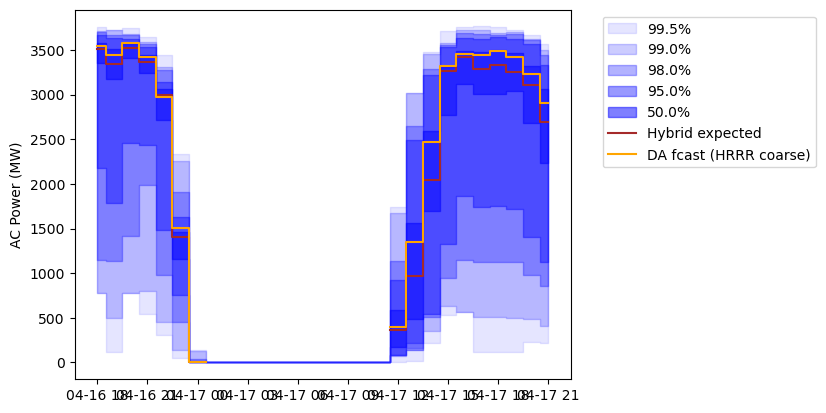

In [20]:
for i in range(num_intervals):
    alph=0.1+(i/10.)
    plt.fill_between(result_df.index,# x
                     result_df[str(percentile_list[i])+'_p_ac'].fillna(0), # lower
                     result_df[str(percentile_list[len(percentile_list)-i-1])+'_p_ac'].fillna(0), # upper
                     color='blue',
                     alpha=alph,
                     step='mid',
                     label=(str(pi_list[i]*100)+'%'))
    
plt.plot(result_df.index,
         result_df[str(percentile_list[int((len(percentile_list)-1)/2)])+'_p_ac'],
         label='Hybrid expected',color='brown', drawstyle='steps-mid')
# plt.plot(result_df.index,result_df['p_ac_all_act'],label='actual',color='black', drawstyle='steps-mid')
plt.plot(result_df.index,result_df['p_ac_all_fcast'],label='DA fcast (HRRR coarse)',color='orange', drawstyle='steps-mid')
plt.ylabel('AC Power (MW)')
# plt.ylim([0,4500])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [21]:
result_df

,tcc_std,max_min_norm,csi_fcast,zen,az,month,p_ac_all_fcast,p_ac_all_fcast_max,p_ac_all_fcast_min,p_ac_all_cs,...,0.005_p_ac,0.01_p_ac,0.025_p_ac,0.25_p_ac,0.5_p_ac,0.75_p_ac,0.975_p_ac,0.99_p_ac,0.995_p_ac,0.9975_p_ac
time_center_labeled,,,,,,,,,,,,,,,,,,,,,
2024-04-16 18:00:00+00:00,5.557877,0.215213,0.959591,23.094079,196.468064,4.0,3539.876043,3663.199470,2869.292884,3688.941695,...,781.702872,1146.729163,2180.620499,3350.395186,3505.645503,3574.145119,3671.570733,3700.328740,3715.006920,3757.135922
2024-04-16 19:00:00+00:00,7.766840,0.295706,0.933021,29.795953,226.462330,4.0,3442.721747,3663.607733,2572.490512,3689.866345,...,501.614783,1138.854546,1783.424462,3169.328072,3337.033242,3508.607498,3631.237219,3662.948439,3719.125667,3719.998748
2024-04-16 20:00:00+00:00,7.766840,0.167640,0.972310,40.238388,244.837673,4.0,3572.065163,3640.379441,3024.503490,3673.793885,...,778.492985,1419.411046,2459.375967,3406.257721,3520.360498,3567.846905,3621.605311,3663.570372,3674.154756,3741.708087
2024-04-16 21:00:00+00:00,7.766840,0.114066,0.955303,52.141873,256.981674,4.0,3415.072158,3530.204396,3122.435977,3574.857973,...,795.450207,1991.820783,2440.343874,3236.220312,3363.904960,3440.164428,3532.804659,3566.033505,3592.335068,3640.943234
2024-04-16 22:00:00+00:00,10.913607,0.189790,0.871493,64.588255,266.288725,4.0,2975.249608,3187.511485,2539.573461,3413.970060,...,448.462853,979.775223,1479.564583,2709.808740,2997.266098,3066.231051,3139.157250,3278.628453,3311.389079,3441.847414
2024-04-16 23:00:00+00:00,10.913607,0.249538,0.640026,77.144279,274.434249,4.0,1503.059519,1756.776809,1170.753856,2348.434934,...,139.025922,456.509395,755.096027,1161.440799,1402.304582,1464.325724,1630.720213,1912.793054,2259.638724,2331.302890
2024-04-17 00:00:00+00:00,10.913607,0.018348,0.043666,89.236555,282.393788,4.0,8.539227,10.040231,6.452026,195.559638,...,1.298568,1.206363,1.471741,5.126280,5.072349,5.152003,13.862741,44.007709,123.083852,141.073141
2024-04-17 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-17 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
